In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
from time import process_time

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit_ibm_provider import IBMProvider

# Loading your IBM Quantum account(s)
provider = IBMProvider()
import numpy as np
from docplex.mp.model import Model

# Qiskit packages
from qiskit import BasicAer

# Importing standard Qiskit libraries
from qiskit.algorithms import QAOA
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer, CplexOptimizer, MinimumEigenOptimizer
from qiskit_optimization.translators import from_docplex_mp

In [ ]:
#pip install qiskit_ibm_provider

In [2]:
#pip install cplex ### If you don't have Cplex installed in your environment or get a error regarding cplex optimizer, then uncomment this line to install cplex ###

Note: you may need to restart the kernel to use updated packages.


# Initializing our Vehicle Routing Problem

In [3]:
n=int (input("Number of locations: "))
K=int (input("Number of vehicles: "))

Number of locations:  5
Number of vehicles:  5


In [4]:
# Defining our Initialization class

class Initializer:

    def __init__(self, n):
        self.n = n

    def generate_nodes_and_weight_matrix(self):

        n = self.n

        #np.random.seed(42)

        x = (np.random.rand(n) - 0.5) * 10
        y = (np.random.rand(n) - 0.5) * 10

        weight_matrix = np.zeros([n, n])
        for i in range(n):
            for j in range(i+1, n):
                weight_matrix[i, j] = (x[i] - x[j]) ** 2 + (y[i] - y[j]) ** 2
                weight_matrix[j, i] = weight_matrix[i, j]

        return x, y, weight_matrix

In [5]:
# Initialize the problem by randomly generating the nodes and weight

initializer = Initializer(n)
x,y,weight_matrix = initializer.generate_nodes_and_weight_matrix()

# Quantum Optimization with Warm Starting QAOA

In [6]:
# Defining our Quantum Optimizer class

class QuantumOptimizerWarmStart:

    def __init__(self, weight_matrix, n, K):

        self.weight_matrix = weight_matrix
        self.n = n
        self.K = K

    def binary_representation_warm_start(self, x_sol=0):

        weight_matrix = self.weight_matrix
        n = self.n
        K = self.K

        A = np.max(weight_matrix) * 100  # A parameter of cost function

        # Determine the weights w
        weight_matrix_vec = weight_matrix.reshape(n ** 2)
        w_list = [weight_matrix_vec[x] for x in range(n ** 2) if weight_matrix_vec[x] > 0]
        w = np.zeros(n * (n - 1))
        for i in range(len(w_list)):
            w[i] = w_list[i]

        # Some variables I will use
        Id_n = np.eye(n)
        Im_n_1 = np.ones([n - 1, n - 1])
        Iv_n_1 = np.ones(n)
        Iv_n_1[0] = 0
        Iv_n = np.ones(n - 1)
        neg_Iv_n_1 = np.ones(n) - Iv_n_1

        v = np.zeros([n, n * (n - 1)])
        for i in range(n):
            count = i - 1
            for j in range(n * (n - 1)):

                if j // (n - 1) == i:
                    count = i

                if j // (n - 1) != i and j % (n - 1) == count:
                    v[i][j] = 1.

        vn = np.sum(v[1:], axis=0)

        # Q defines the interactions between variables
        Q = A * (np.kron(Id_n, Im_n_1) + np.dot(v.T, v))

        # g defines the contribution from the individual variables
        g = w - 2 * A * (np.kron(Iv_n_1, Iv_n) + vn.T) - \
            2 * A * K * (np.kron(neg_Iv_n_1, Iv_n) + v[0].T)

        # c is the constant offset
        c = 2 * A * (n - 1) + 2 * A * (K ** 2)

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = lambda x: np.dot(np.around(x), np.dot(Q, np.around(x))) + np.dot(g, np.around(x)) + c
            cost = fun(x_sol)
        except:
            cost = 0

        return Q, g, c, cost

    def construct_problem_warm_start(self, Q, g, c) -> QuadraticProgram:
        mdl = Model()
        x = [mdl.binary_var('x%s' % i) for i in range(n * (n - 1))]

        objective = mdl.sum([g[i] * x[i] for i in range(n * (n - 1))])
        objective += mdl.sum(
            [Q[i, j] * x[i] * x[j] for i in range(n * (n - 1)) for j in range(n * (n - 1))])
        objective += mdl.sum(c)
        mdl.minimize(objective)
        cost = mdl.sum(x)
        # mdl.add_constraint(cost <= n*(n-1))
        # mdl.add_constraint(cost >= 0)
        qp = from_docplex_mp(mdl)
        return qp

    def solve_problem_warm_start(self, qp):
        algorithm_globals.random_seed = 43
        quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'),
                                           seed_simulator=algorithm_globals.random_seed,
                                           seed_transpiler=algorithm_globals.random_seed)

        qaoa = QAOA(quantum_instance=quantum_instance, initial_point=[0., 1.])
        ws_qaoa = WarmStartQAOAOptimizer(pre_solver=CplexOptimizer(), relax_for_pre_solver=True, qaoa=qaoa,
                                         epsilon=0.0)
        result = ws_qaoa.solve(qp)
        # compute cost of the obtained result
        _, _, _, level = self.binary_representation_warm_start(x_sol=result.x)
        return result, result.x, level

In [7]:
# Instantiate the quantum optimizer class with parameters:
quantum_optimizer_warm_start = QuantumOptimizerWarmStart(weight_matrix, n, K)

In [8]:
Q_warm_start, g_warm_start, c_warm_start, binary_cost_warm_start = quantum_optimizer_warm_start.binary_representation_warm_start()

In [9]:
qp_warm_start = quantum_optimizer_warm_start.construct_problem_warm_start(Q_warm_start, g_warm_start, c_warm_start)
print(qp_warm_start)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex_model1

Minimize
 obj: - 73596.904450919756 x0 - 73560.931412470265 x1 - 73548.240960018622 x2
      - 73596.881156280782 x3 - 73596.904450919756 x4 - 24492.877514744137 x5
      - 24474.641331199731 x6 - 24532.530524991133 x7 - 73560.931412470265 x8
      - 24492.877514744137 x9 - 24524.640874012217 x10 - 24489.298996987432 x11
      - 73548.240960018622 x12 - 24474.641331199731 x13 - 24524.640874012217 x14
      - 24471.291123748873 x15 - 73596.881156280782 x16 - 24532.530524991133 x17
      - 24489.298996987432 x18 - 24471.291123748873 x19 + [
      24532.622680449997 x0^2 + 24532.622680449997 x0*x1
      + 24532.622680449997 x0*x2 + 24532.622680449997 x0*x3
      + 24532.622680449997 x0*x9 + 24532.622680449997 x0*x13
      + 24532.622680449997 x0*x17 + 24532.622680449997 x1^2
      + 24532.622680449997 x1*x2 + 24532.622680449997 x1*x3
      + 24532.622680449997 x1*x5 + 24532.622680449997 x1*x14
 

In [10]:
### Solving Vehicle Routing Problem with Warm Starting QAOA ###
t_start = process_time()
quantum_warm_start, quantum_solution_warm_start, quantum_cost_warm_start = quantum_optimizer_warm_start.solve_problem_warm_start(qp_warm_start)
t_stop = process_time()
t = t_stop-t_start
   
print("Elapsed time during the whole program in seconds:", t)

print(quantum_solution_warm_start, quantum_cost_warm_start)

Elapsed time during the whole program in seconds: 39.574149056
[1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.] 12443.339711646142


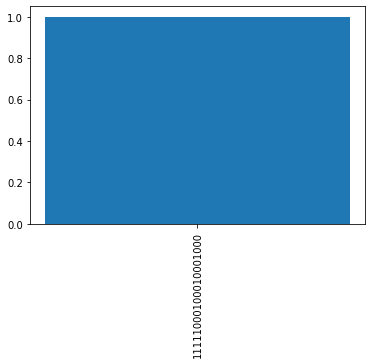

In [11]:
### Plotting Samples to Bar Graph ###
def samples_to_graph(data):
    data_val={}
    data_prob={}
    for i in data:
        arr=i.x.tolist()
        arr=[str(int(i)) for i in arr]
        key=''.join(arr)
        data_val[key]=i.fval
        data_prob[key]=i.probability
    data_val_sorted=sorted(data_val, key=data_val.get)
    least_10=data_val_sorted[0:10]
    plot_dic={}
    for i in least_10:
        plot_dic[i]=data_prob[i]
    plt.xticks(rotation=90)
    plt.bar(range(len(plot_dic)), plot_dic.values(), tick_label=least_10)
    
    return least_10[0], plot_dic
    
optimal_10_warm_start, optimal_10_prob_warm_start = samples_to_graph(quantum_warm_start.samples) #The most optimal solutions will be plotted in descending order with most optimal solution being the first

In [12]:
def visualize_solution(xc, yc, x, C, n, K, title_str):
    plt.figure()
    plt.scatter(xc, yc, s=200)
    for i in range(len(xc)):
        plt.annotate(i, (xc[i] + 0.15, yc[i]), size=16, color='r')
    plt.plot(xc[0], yc[0], 'r*', ms=20)

    plt.grid()

    for ii in range(0, n ** 2):

        if x[ii] > 0:
            ix = ii // n
            iy = ii % n
            plt.arrow(xc[ix], yc[ix], xc[iy] - xc[ix], yc[iy] - yc[ix], length_includes_head=True, head_width=.25)


    plt.title(title_str+' cost = ' + str(int(C * 100) / 100.))
    plt.show()

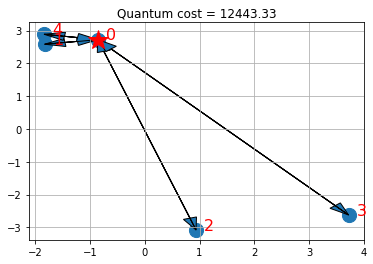

In [13]:
# Put the solution in a way that is compatible with the classical variables
x_quantum = np.zeros(n**2)
kk = 0
for ii in range(n ** 2):
    if ii // n != ii % n:
        x_quantum[ii] = quantum_solution_warm_start[kk]
        kk +=  1

# visualize the solution
visualize_solution(x, y, x_quantum, quantum_cost_warm_start, n, K, 'Quantum')

In [14]:
### Making a Dataframe of obtained results ###
def solutions_to_df(n, K, optimal_10, quantum_cost, optimal_10_prob):
    dfdata = np.array([n, K, optimal_10, quantum_cost, optimal_10_prob[optimal_10], t])
    df = pd.DataFrame(data=dfdata, index=['n (No. of locations)', 'K (No. of vehicles)', 'Quantum Solution', 'Quantum Cost', 'Probability', 'Execution Time (in s)']).transpose()
    return df

In [36]:
### Combining all the Warm Starting QAOA results into a single Dataframe and saving it as a file ###
filename = 'results_warm_start_QAOA.csv'
if os.path.isfile(filename): 
    result_df_warm_start = pd.read_csv(filename)
    df_warm_start = solutions_to_df(n, K, optimal_10_warm_start, quantum_cost_warm_start, optimal_10_prob_warm_start) 
    result_df_warm_start = result_df_warm_start.append(df_warm_start)
else:
    df_warm_start = solutions_to_df(n, K, optimal_10_warm_start, quantum_cost_warm_start, optimal_10_prob_warm_start)
    result_df_warm_start = pd.DataFrame(df_warm_start)
result_df_warm_start.to_csv(filename)
result_df_warm_start[['n (No. of locations)', 'K (No. of vehicles)', 'Quantum Solution', 'Quantum Cost', 'Probability', 'Execution Time (in s)']]

,n (No. of locations),K (No. of vehicles),Quantum Solution,Quantum Cost,Probability,Execution Time (in s)
1,4,2,11100100010,142.499906,0.011719,0.97977
2,4,3,111100100100,136.569436,0.999023,0.568725
3,5,2,10101000000110000010,123.297116,0.999023,33.383051
4,5,3,11101000000110001000,277.819396,0.015625,34.144786
5,5,4,11111000100010001000,189.112716,0.999023,33.061631


# Quantum Optimization with Standard QAOA

In [16]:
#Defining our Quantum Optimizer class

class QuantumOptimizer:

    def __init__(self, weight_matrix, n, K):

        self.weight_matrix = weight_matrix
        self.n = n
        self.K = K

    def binary_representation(self,x_sol=0):

        weight_matrix = self.weight_matrix
        n = self.n
        K = self.K

        A = np.max(weight_matrix) * 100  # A parameter of cost function

        # Determine the weights w
        weight_matrix_vec = weight_matrix.reshape(n ** 2)
        w_list = [weight_matrix_vec[x] for x in range(n ** 2) if weight_matrix_vec[x] > 0]
        w = np.zeros(n * (n - 1))
        for i in range(len(w_list)):
            w[i] = w_list[i]

        # Some variables I will use
        Id_n = np.eye(n)
        Im_n_1 = np.ones([n - 1, n - 1])
        Iv_n_1 = np.ones(n)
        Iv_n_1[0] = 0
        Iv_n = np.ones(n-1)
        neg_Iv_n_1 = np.ones(n) - Iv_n_1

        v = np.zeros([n, n*(n-1)])
        for i in range(n):
            count = i-1
            for j in range(n*(n-1)):

                if j//(n-1) == i:
                    count = i

                if j//(n-1) != i and j%(n-1) == count:
                    v[i][j] = 1.

        vn = np.sum(v[1:], axis=0)

        # Q defines the interactions between variables
        Q = A*(np.kron(Id_n, Im_n_1) + np.dot(v.T, v))

        # g defines the contribution from the individual variables
        g = w - 2 * A * (np.kron(Iv_n_1,Iv_n) + vn.T) - \
                2 * A * K * (np.kron(neg_Iv_n_1, Iv_n) + v[0].T)

        # c is the constant offset
        c = 2 * A * (n-1) + 2 * A * (K ** 2)

        try:
            max(x_sol)
            # Evaluates the cost distance from a binary representation of a path
            fun = lambda x: np.dot(np.around(x), np.dot(Q, np.around(x))) + np.dot(g, np.around(x)) + c
            cost = fun(x_sol)
        except:
            cost = 0

        return Q, g, c, cost

    def construct_problem(self, Q, g, c) -> QuadraticProgram:
        qp = QuadraticProgram()
        for i in range(n * (n - 1)):
            qp.binary_var()
        qp.objective.quadratic = Q
        qp.objective.linear = g
        qp.objective.constant = c
        return qp

    def solve_problem(self, qp):
        algorithm_globals.random_seed = 43
        quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'),
                                           seed_simulator=algorithm_globals.random_seed,
                                           seed_transpiler=algorithm_globals.random_seed)

        qaoa = QAOA(quantum_instance=quantum_instance, initial_point=[0., 1.])
        optimizer = MinimumEigenOptimizer(min_eigen_solver=qaoa)
        result = optimizer.solve(qp)
        # compute cost of the obtained result
        _,_,_,level = self.binary_representation(x_sol=result.x)
        return result, result.x, level

In [17]:
# Instantiate the quantum optimizer class with parameters:
quantum_optimizer = QuantumOptimizer(weight_matrix, n, K)

In [ ]:
Q, g, c, binary_cost = quantum_optimizer.binary_representation()

In [19]:
qp = quantum_optimizer.construct_problem(Q, g, c)
print(qp)

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: - 73596.904450919756 x0 - 73560.931412470265 x1 - 73548.240960018622 x2
      - 73596.881156280782 x3 - 73596.904450919756 x4 - 24492.877514744137 x5
      - 24474.641331199731 x6 - 24532.530524991133 x7 - 73560.931412470265 x8
      - 24492.877514744137 x9 - 24524.640874012217 x10 - 24489.298996987432 x11
      - 73548.240960018622 x12 - 24474.641331199731 x13 - 24524.640874012217 x14
      - 24471.291123748873 x15 - 73596.881156280782 x16 - 24532.530524991133 x17
      - 24489.298996987432 x18 - 24471.291123748873 x19 + [
      24532.622680449997 x0^2 + 24532.622680449997 x0*x1
      + 24532.622680449997 x0*x2 + 24532.622680449997 x0*x3
      + 24532.622680449997 x0*x9 + 24532.622680449997 x0*x13
      + 24532.622680449997 x0*x17 + 24532.622680449997 x1^2
      + 24532.622680449997 x1*x2 + 24532.622680449997 x1*x3
      + 24532.622680449997 x1*x5 + 24532.622680449997 x1*x14
      + 24

In [20]:
### Solving Vehicle Routing Problem with Standard QAOA ###
t_start = process_time()
quantum, quantum_solution, quantum_cost = quantum_optimizer.solve_problem(qp)
t_stop = process_time()
t = t_stop-t_start
   
print("Elapsed time during the whole program in seconds:", t)

print(quantum_solution, quantum_cost)

Elapsed time during the whole program in seconds: 1642.728246231
[0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1.] 73843.61864696088


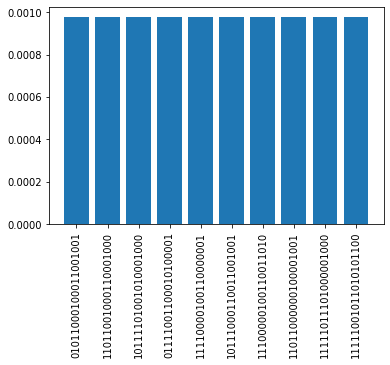

In [21]:
### Plotting Samples to Bar Graph ###
    
optimal_10, optimal_10_prob = samples_to_graph(quantum.samples) #The most optimal solutions will be plotted in descending order with most optimal solution being the first

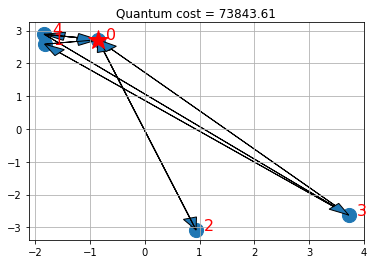

In [22]:
# Put the solution in a way that is compatible with the classical variables
x_quantum = np.zeros(n**2)
kk = 0
for ii in range(n ** 2):
    if ii // n != ii % n:
        x_quantum[ii] = quantum_solution[kk]
        kk +=  1

# visualize the solution
visualize_solution(x, y, x_quantum, quantum_cost, n, K, 'Quantum')

In [37]:
### Combining all the Standard QAOA results into a single Dataframe and saving it as a file ###
filename = 'results_standard_QAOA.csv'
if os.path.isfile(filename):
    result_df_standard = pd.read_csv(filename)
    df_standard = solutions_to_df(n, K, optimal_10, quantum_cost, optimal_10_prob)
    result_df_standard = result_df_standard.append(df_standard)
else:
    df_standard = solutions_to_df(n, K, optimal_10, quantum_cost, optimal_10_prob)
    result_df_standard = pd.DataFrame(df_standard)
result_df_standard.to_csv(filename)
result_df_standard[['n (No. of locations)', 'K (No. of vehicles)', 'Quantum Solution', 'Quantum Cost', 'Probability', 'Execution Time (in s)']]

,n (No. of locations),K (No. of vehicles),Quantum Solution,Quantum Cost,Probability,Execution Time (in s)
1,4,2,101010100100,151.663796,0.000977,54.211239
2,4,3,111100100100,136.569436,0.001953,30.251411
3,5,2,10010100110000000001,39618.816793,0.000977,1093.039768
4,5,3,11101000100100101000,20653.43979,0.000977,1233.220584
5,5,4,11110010100010001000,22999.934887,0.000977,1283.739113


# Comparing Standard QAOA and Warm Starting QAOA

### Comparing Quantum Cost computed using Standard QAOA vs Warm Starting QAOA

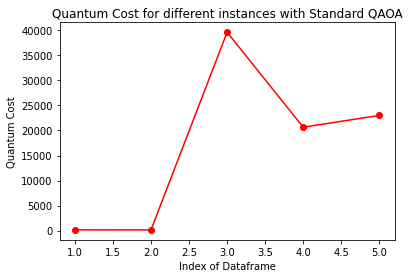

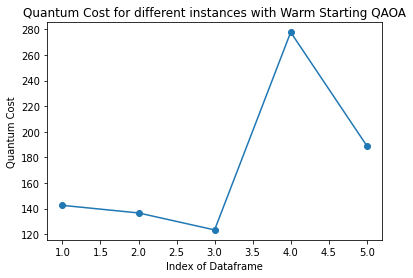

In [49]:
index = result_df_standard.index
standard_np_q_cost = result_df_standard['Quantum Cost'].to_numpy()
plt.plot(index, standard_np_q_cost, marker='o', color='red')
plt.title('Quantum Cost for different instances with Standard QAOA')
plt.xlabel('Index of Dataframe')
plt.ylabel('Quantum Cost')
plt.show()

index_warm = result_df_warm_start.index
warm_start_np_q_cost = result_df_warm_start['Quantum Cost'].to_numpy()
plt.plot(index_warm, warm_start_np_q_cost, marker='o')
plt.title('Quantum Cost for different instances with Warm Starting QAOA')
plt.xlabel('Index of Dataframe')
plt.ylabel('Quantum Cost')
plt.show()

### Comparing Probability computed using Standard QAOA vs Warm Starting QAOA

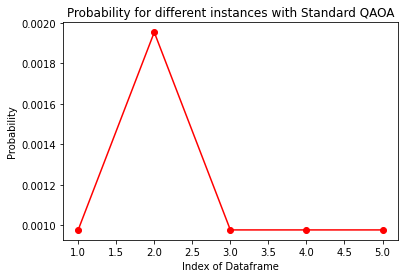

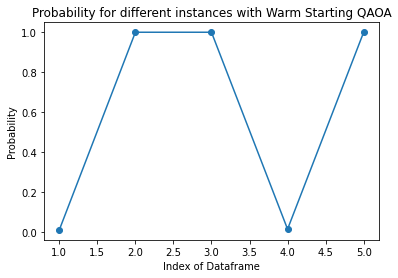

In [51]:
index = result_df_standard.index
standard_np_q_prob = result_df_standard['Probability'].to_numpy()
plt.plot(index, standard_np_q_prob, marker='o', color='red')
plt.title('Probability for different instances with Standard QAOA')
plt.xlabel('Index of Dataframe')
plt.ylabel('Probability')
plt.show()

index_warm = result_df_warm_start.index
warm_start_np_q_prob = result_df_warm_start['Probability'].to_numpy()
plt.plot(index_warm, warm_start_np_q_prob, marker='o')
plt.title('Probability for different instances with Warm Starting QAOA')
plt.xlabel('Index of Dataframe')
plt.ylabel('Probability')
plt.show()

### Comparing Execution Time (in s) computed using Standard QAOA vs Warm Starting QAOA

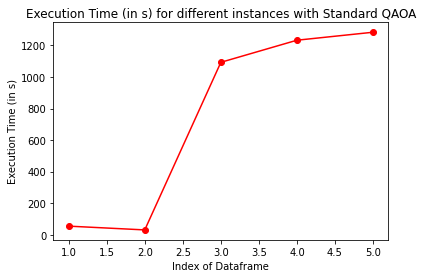

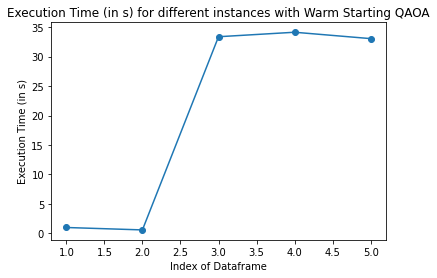

In [52]:
index = result_df_standard.index
standard_np_q_time = result_df_standard['Execution Time (in s)'].to_numpy()
plt.plot(index, standard_np_q_time, marker='o', color='red')
plt.title('Execution Time (in s) for different instances with Standard QAOA')
plt.xlabel('Index of Dataframe')
plt.ylabel('Execution Time (in s)')
plt.show()

index_warm = result_df_warm_start.index
warm_start_np_q_time = result_df_warm_start['Execution Time (in s)'].to_numpy()
plt.plot(index_warm, warm_start_np_q_time, marker='o')
plt.title('Execution Time (in s) for different instances with Warm Starting QAOA')
plt.xlabel('Index of Dataframe')
plt.ylabel('Execution Time (in s)')
plt.show()